In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from implementations import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [5]:
#unzip csv 
import zipfile
with zipfile.ZipFile('../data/test.csv.zip') as zip_ref:
    zip_ref.extractall(r"../data")

In [6]:
from proj1_helpers import *

#load data
DATA_TRAIN_PATH = '../data/train.csv' #download train data and supply path here 
y, x, ids = load_csv_data(DATA_TRAIN_PATH)

#add constant term
tx = np.c_[np.ones((y.shape[0], 1)), x]

print(y.shape, tx.shape, ids.shape)

(250000,) (250000, 31) (250000,)


## Do your thing crazy machine learning thing here 

### Exploratory Data Analysis

#### Correlation matrix

In [5]:
#corr_matrix = np.corrcoef(tx) gives allocation error
corr_matrix = np.corrcoef(tx.T)

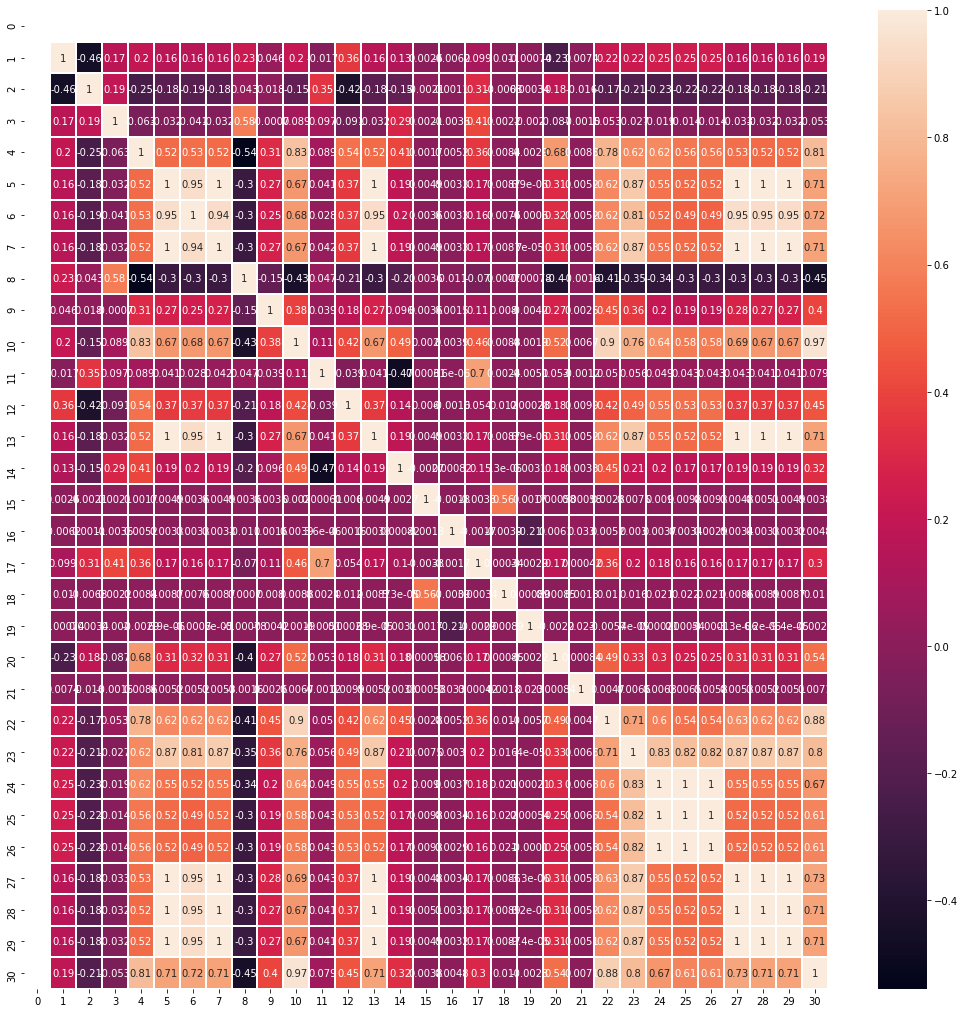

In [6]:
plt.figure(figsize = (18,18))
ax = sns.heatmap(corr_matrix, annot=True,linewidths=1, linecolor='white')

### Feature  processing

#### Removing the correlated colummns

In [54]:
columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [55]:
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [56]:
selected_columns = tx_train.columns[columns].values
selected_columns

array(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'PRI_tau_pt', 'PRI_tau_eta',
       'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi',
       'PRI_met', 'PRI_met_phi', 'PRI_jet_num', 'PRI_jet_leading_pt'],
      dtype=object)

In [57]:
rejected_columns = [x for x, y in zip(tx_train.columns, columns) if y == False]
rejected_columns

['DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_met_sumet',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_jet_all_pt']

In [58]:
tx_train_filtered = tx_train[selected_columns]

In [59]:
tx_train_filtered.values.shape

(250000, 20)

#### Substituting missing features by the mean of the respective column

In [5]:
for i in range(tx.shape[1]):
    idx = tx[:,i] > -999
    mean = np.mean(tx[idx,i])
    tx[idx==False,i] = mean

#### Standardize the data

In [7]:
# standardized data
tx_std = standardize(tx)
tx_std

/home/ML-2020/project1/scripts/helpers.py:59: RuntimeWarning: invalid value encountered in true_divide
  return (x-mean)/std


array([[        nan,  0.46141372,  0.06833197, ...,  1.5668    ,
         1.55858439,  0.4125105 ],
       [        nan,  0.51670419,  0.55250482, ..., -0.63936657,
        -0.63936694, -0.27381996],
       [        nan, -2.33785898,  3.19515553, ..., -0.63936657,
        -0.63936694, -0.29396985],
       ...,
       [        nan,  0.38016991,  0.31931645, ..., -0.63936657,
        -0.63936694, -0.31701723],
       [        nan,  0.35431502, -0.84532397, ..., -0.63936657,
        -0.63936694, -0.74543941],
       [        nan, -2.33785898,  0.66533608, ..., -0.63936657,
        -0.63936694, -0.74543941]])

### 

### Finding the model

In [19]:
gamma = 0.1
max_iters = 100
initial_w = np.zeros(31)
lambda_ = 0.00001

regression_res = [least_squares_GD(y, tx_std, initial_w, max_iters,gamma),
                  least_squares_SGD(y, tx_std, initial_w, max_iters, gamma),
                  least_squares(y, tx_std),
                  ridge_regression(y,tx_std,0.00001),
                  logistic_regression(y, tx_std, initial_w, max_iters, gamma),
                  reg_logistic_regressions(y, tx_std, lambda_, initial_w, max_iters, gamma)]
regression_names = ["Gradient Descent","Stochastic Gradient Descent", "Least Squares", "Ridge Regression1",'Logistic Ridge Regression','Reg Logistic Ridge Regression']
for i in range (len(regression_res)):
    w,loss = regression_res[i]
    print("{name}, w*={w}, loss={l}\n".format(name=regression_names[i],w=w, l=loss))

Gradient Descent, w*=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan], loss=nan

Stochastic Gradient Descent, w*=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan], loss=nan

Least Squares, w*=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan], loss=nan

Ridge Regression1, w*=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan], loss=nan

Logistic Ridge Regression, w*=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan], loss=nan

Reg Logistic Ridge Regression, w*=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan], loss=nan



### without standardization -> lower loss

In [10]:
gamma = 0.01
max_iters = 30
initial_w = np.zeros(31)
lambda_ = 0.00001

regression_res = [least_squares_GD(y, tx, initial_w, max_iters,gamma),
                  least_squares_SGD(y, tx, initial_w, max_iters, gamma),
                  least_squares(y, tx),
                  ridge_regression(y,tx,0.00001),
                  logistic_regression(y, tx, initial_w, max_iters, gamma),
                  reg_logistic_regressions(y, tx, lambda_, initial_w, max_iters, gamma)]
regression_names = ["Gradient Descent","Stochastic Gradient Descent", "Least Squares", "Ridge Regression1",'Logistic Ridge Regression','Reg Logistic Ridge Regression']
print('-----Without standardization-----')
for i in range (len(regression_res)):
    w,loss = regression_res[i]
    print("{name}, w*={w}, loss={l}\n".format(name=regression_names[i],w=w, l=loss))

/home/ML-2020/project1/scripts/implementations.py:98: RuntimeWarning: divide by zero encountered in log
  B = np.log(1+np.exp(tx@w))


KeyboardInterrupt: 

In [36]:
tx.shape

(250000, 31)

### Cross Validation

In [8]:
from implementations import *

def validade_CV(y, x):
    seed = 1
    degree = 0
    k_fold = 4
    lambdas = np.logspace(-9, -3, 30)
    gamma = 0.01
    max_iters = 30
    initial_w = np.zeros(31)
    lambda_ = 0.00001
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    mse_tr = []
    mse_te = []

    # cross validation using ridge regression
    for ind, lambda_ in enumerate(lambdas):
        mse_pfold_tr = []
        mse_pfold_te = []
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, tx, k_indices, k, initial_w,lambda_ ,max_iters, gamma, degree)
            mse_pfold_tr.append(loss_tr)
            mse_pfold_te.append(loss_te)
        mse_tr.append(np.mean(mse_pfold_tr))
        mse_te.append(np.mean(mse_pfold_te)) 
    
    #cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.semilogx(lambdas, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambdas, mse_te, marker=".", color='r', label='test error')

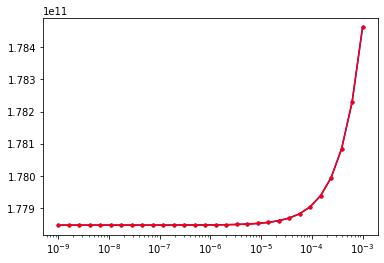

In [9]:
validade_CV(y, tx)

#### Boxplots

In [40]:
 build_poly(tx, 0)

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

## Generate predictions and save ouput in csv format for submission:

In [ ]:
# signal  (a  Higgs  boson) --> 1 
# background --> -1 

In [58]:
weights = np.zeros(30)
indices_columns = [tx_train.columns.get_loc(i) for i in selected_columns]
weights[indices_columns] = [ 6.49068887e-05, -7.38458962e-03, -6.25745258e-03, -9.56566507e-04
  ,5.67241481e-04,  3.38487971e-01 ,-5.55261480e-04 ,-9.49454910e-04,
 -2.23810219e-01 , 1.01480469e-01  ,8.97939743e-03 ,-8.18127388e-04,
 -7.17372823e-04  ,1.38807526e-02 ,-6.89532755e-04  ,1.35488914e-03,
  3.79261374e-03  ,5.73273679e-04, -3.16206085e-01  ,3.83182264e-04]

In [67]:
weights = ridge_regression(y,tx,0.00001)[0]

In [60]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_test, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [68]:
OUTPUT_PATH = '../data/results.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tx_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
#first comment